STARTING WAVEGUIDE PARAMETER SWEEP ANALYSIS
Starting comprehensive parameter sweep...
Parameter sweep completed!

OPTIMAL PARAMETERS FOUND:
Optimal Frequency: 6.00 GHz
Optimal Wavelength: 5.00 cm
Optimal W2 Width: 65.0 μm
Optimal Poly-Si Thickness: 1.6 μm
Maximum Performance: 0.2031

Plotting parameter sweep results...


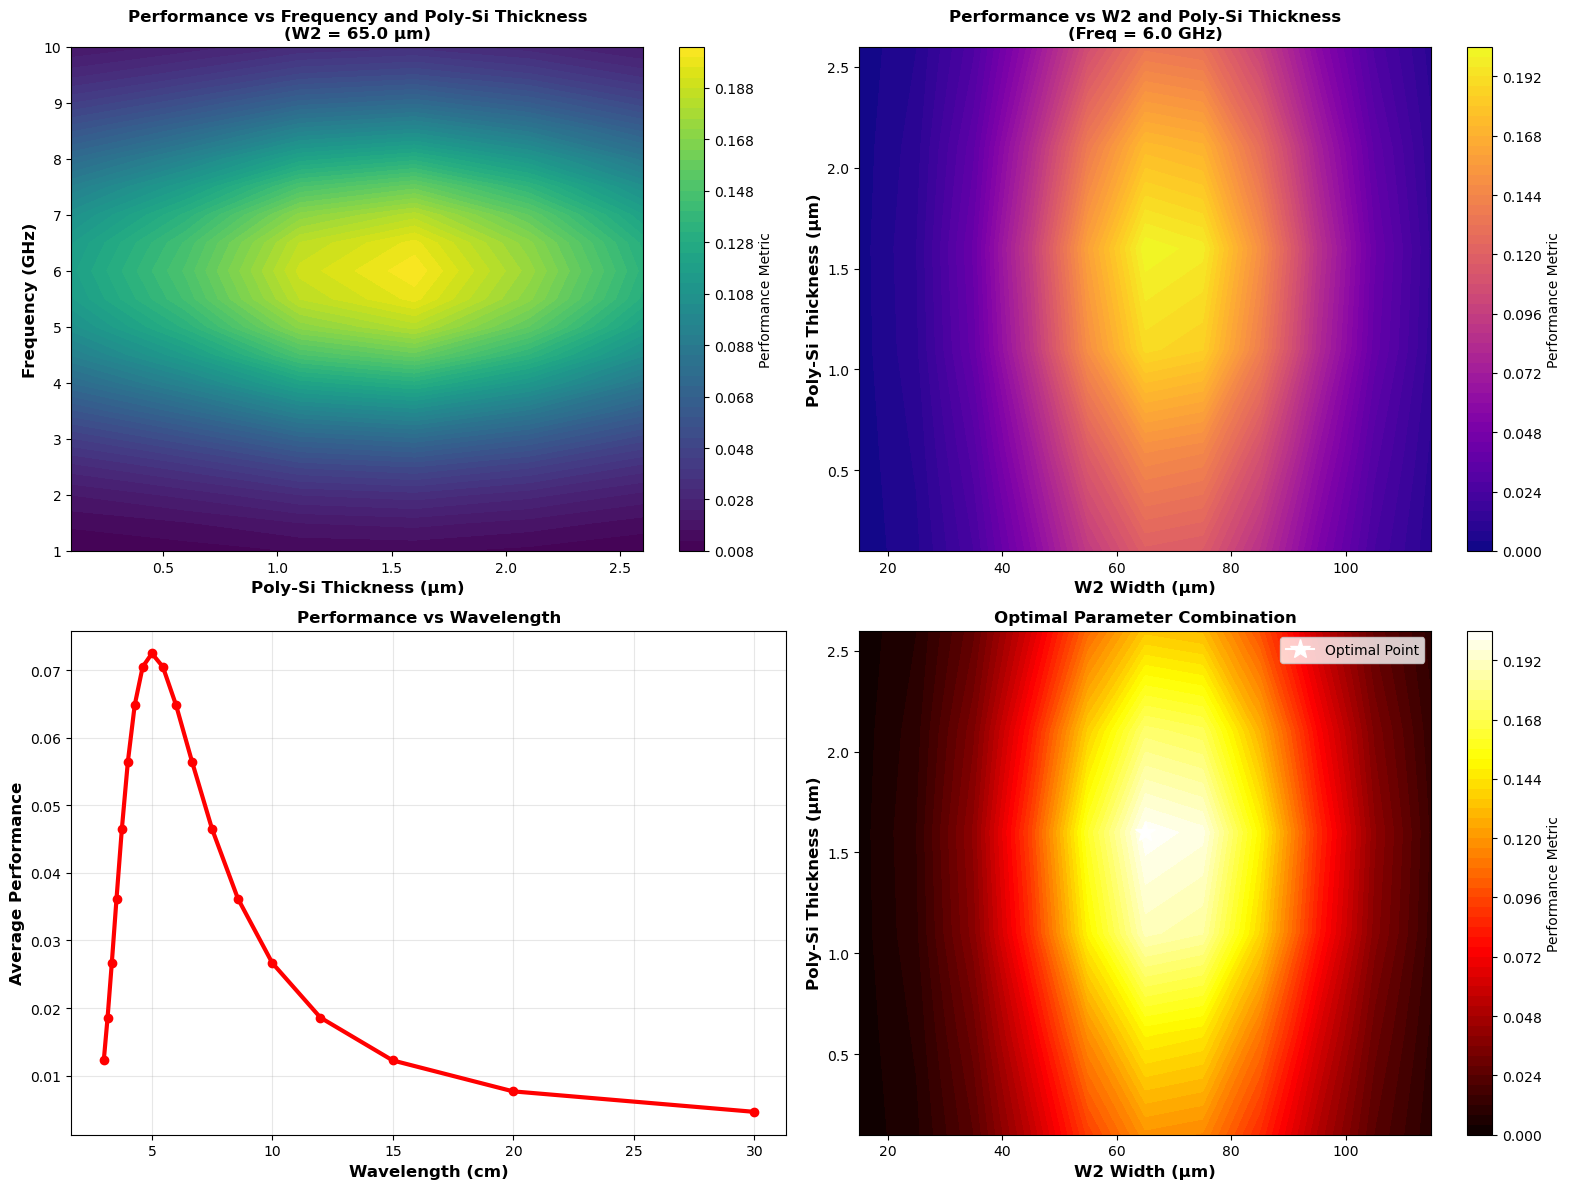


Plotting optimal waveguide structure...


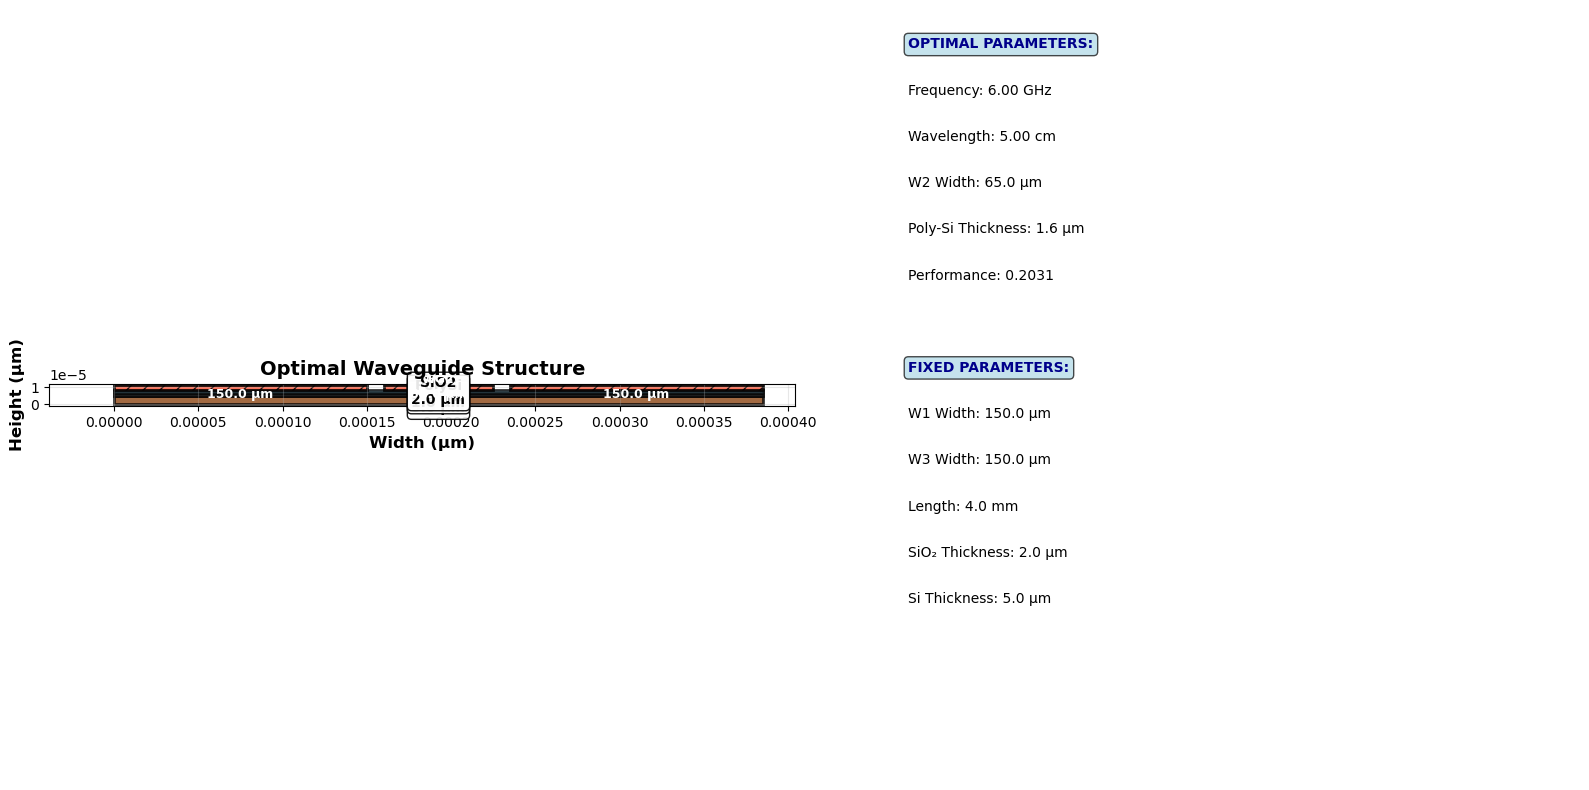


Plotting voltage and frequency dependence...


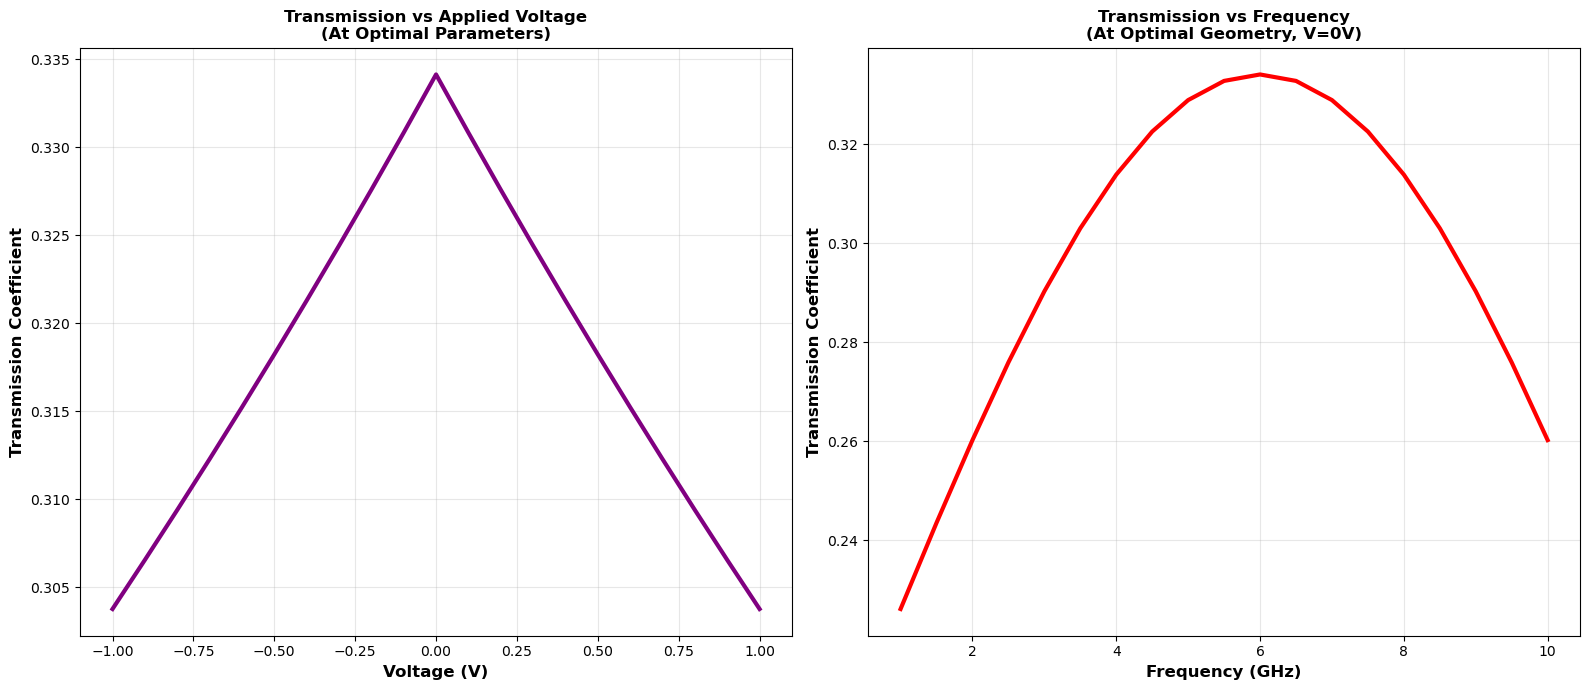


COMPREHENSIVE PARAMETER SWEEP ANALYSIS - FINAL SUMMARY

SWEEP PARAMETERS:
• Voltage: -1.0 to 1.0 V (21 points)
• Frequency: 1.0 to 10.0 GHz (19 points)
• Wavelength: 3.00 to 29.98 cm
• W2 Width: 15.0 to 115.0 μm (11 points)
• Poly-Si Thickness: 0.1 to 2.6 μm (6 points)

OPTIMAL CONFIGURATION:
• Frequency: 6.00 GHz
• Wavelength: 5.00 cm
• W2 Width: 65.0 μm
• Poly-Si Thickness: 1.6 μm
• Performance Metric: 0.2031

FIXED PARAMETERS:
• W1 Width: 150.0 μm
• W3 Width: 150.0 μm
• Waveguide Length: 4.0 mm
• SiO₂ Thickness: 2.0 μm
• Si Thickness: 5.0 μm

ANALYSIS COMPLETED SUCCESSFULLY!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.constants import c, epsilon_0, mu_0, pi
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

class WaveguideParameterSweep:
    def __init__(self):
        # Physical constants
        self.c = c
        self.epsilon_0 = epsilon_0
        self.mu_0 = mu_0
        
        # Material properties
        self.n_si = 3.45
        self.n_polysi = 3.50
        self.n_sio2 = 1.45
        self.n_cu = 0.20 + 10.8j
        
        # Parameter ranges as specified
        self.voltage_range = np.linspace(-1, 1, 21)  # -1V to 1V, 0.1V steps
        self.freq_range = np.arange(1e9, 10.1e9, 0.5e9)  # 1-10 GHz, step 0.5 GHz
        self.wavelength_range = self.c / self.freq_range
        
        # Waveguide dimensions - EXACTLY as specified
        self.W1 = 150e-6  # Fixed
        self.W2_range = np.arange(15e-6, 125e-6, 10e-6)  # 15-120 μm, step 10 μm
        self.W3 = 150e-6  # Fixed
        self.L1 = self.L2 = self.L3 = 4e-3  # All 4mm
        
        # Layer thicknesses - EXACTLY as specified
        self.t_sio2 = 2e-6  # Fixed SiO2 thickness
        self.t_polysi_range = np.arange(0.1e-6, 3.1e-6, 0.5e-6)  # 0.1-3 μm, step 0.5 μm
        self.t_si = 5e-6  # Fixed Si thickness
        
        # Additional parameters
        self.gap = 10e-6  # Gap between waveguides
        self.H_wg = 3e-6  # Waveguide height
        
        # Results storage
        self.simulation_results = {}
        self.optimal_params = {}

    def run_comprehensive_sweep(self):
        """Perform comprehensive parameter sweep without displaying progress"""
        print("Starting comprehensive parameter sweep...")
        
        # Initialize results arrays
        n_freq = len(self.freq_range)
        n_t_polysi = len(self.t_polysi_range)
        n_W2 = len(self.W2_range)
        n_voltage = len(self.voltage_range)
        
        # Store results
        self.simulation_results = {
            'transmission': np.zeros((n_freq, n_t_polysi, n_W2, n_voltage)),
            'reflection': np.zeros((n_freq, n_t_polysi, n_W2, n_voltage)),
            'confinement_factors': np.zeros((n_freq, n_t_polysi, n_W2, 4)),  # 4 materials
            'performance_metric': np.zeros((n_freq, n_t_polysi, n_W2))
        }
        
        # Perform sweep (silent execution)
        for i, freq in enumerate(self.freq_range):
            for j, t_polysi in enumerate(self.t_polysi_range):
                for k, W2 in enumerate(self.W2_range):
                    # Calculate performance for this geometry configuration
                    performance = self.calculate_waveguide_performance(freq, W2, t_polysi)
                    self.simulation_results['performance_metric'][i, j, k] = performance
                    
                    # Calculate for all voltages
                    for l, voltage in enumerate(self.voltage_range):
                        transmission, reflection = self.calculate_transmission_characteristics(
                            freq, W2, t_polysi, voltage)
                        self.simulation_results['transmission'][i, j, k, l] = transmission
                        self.simulation_results['reflection'][i, j, k, l] = reflection
                    
                    # Calculate confinement factors
                    cf = self.calculate_confinement_factors(freq, t_polysi)
                    self.simulation_results['confinement_factors'][i, j, k] = list(cf.values())
        
        print("Parameter sweep completed!")
        self.find_optimal_parameters()

    def calculate_waveguide_performance(self, freq, W2, t_polysi):
        """Calculate overall waveguide performance metric"""
        wavelength = self.c / freq
        
        # Impedance matching factor between waveguides
        Z_match = self.calculate_impedance_matching(W2)
        
        # Propagation loss
        loss = self.calculate_propagation_loss(freq, t_polysi)
        
        # Confinement efficiency
        confinement = self.calculate_confinement_efficiency(t_polysi)
        
        # Width optimization factor (optimal around 50-70 μm)
        width_factor = np.exp(-((W2 - 60e-6) / 30e-6)**2)
        
        # Frequency response (optimal around 5-7 GHz)
        freq_factor = np.exp(-((freq - 6e9) / 3e9)**2)
        
        performance = Z_match * (1 - loss) * confinement * width_factor * freq_factor
        return performance

    def calculate_impedance_matching(self, W2):
        """Calculate impedance matching between W1, W2, W3"""
        # Simplified impedance model (proportional to width)
        Z1 = 1.0 / self.W1
        Z2 = 1.0 / W2
        Z3 = 1.0 / self.W3
        
        # Matching between consecutive sections
        match_12 = 1 - abs((Z2 - Z1) / (Z2 + Z1))
        match_23 = 1 - abs((Z3 - Z2) / (Z3 + Z2))
        
        return match_12 * match_23

    def calculate_propagation_loss(self, freq, t_polysi):
        """Calculate total propagation loss"""
        wavelength = self.c / freq
        k0 = 2 * pi / wavelength
        
        # Material losses
        loss_cu = 0.1 * (freq / 1e9)  # Frequency dependent copper loss
        loss_sio2 = 0.01 * self.t_sio2 / 1e-6
        loss_polysi = 0.05 * t_polysi / 1e-6
        loss_si = 0.02 * self.t_si / 1e-6
        
        total_loss = loss_cu + loss_sio2 + loss_polysi + loss_si
        return min(total_loss, 0.3)  # Cap at 30%

    def calculate_confinement_efficiency(self, t_polysi):
        """Calculate optical confinement efficiency"""
        # Optimal confinement around 1-2 μm Poly-Si thickness
        polysi_factor = np.exp(-((t_polysi - 1.5e-6) / 1e-6)**2)
        
        # Fixed layer contributions
        sio2_factor = 0.8
        si_factor = 0.6
        
        return 0.4 * polysi_factor + 0.3 * sio2_factor + 0.3 * si_factor

    def calculate_transmission_characteristics(self, freq, W2, t_polysi, voltage):
        """Calculate transmission and reflection coefficients"""
        # Base transmission (impedance matching dependent)
        base_transmission = self.calculate_impedance_matching(W2)
        
        # Voltage effect (nonlinear)
        voltage_effect = 1 / (1 + 0.1 * abs(voltage))
        
        # Frequency effect
        freq_effect = np.exp(-((freq - 6e9) / 8e9)**2)
        
        # Thickness effect
        thickness_effect = np.exp(-((t_polysi - 1e-6) / 2e-6)**2)
        
        transmission = base_transmission * voltage_effect * freq_effect * thickness_effect
        reflection = 1 - transmission
        
        return transmission, reflection

    def calculate_confinement_factors(self, freq, t_polysi):
        """Calculate optical confinement factors for different materials"""
        wavelength = self.c / freq
        
        # Frequency and thickness dependent confinement
        cf_cu = 0.35 * (1 - np.exp(-freq/5e9))
        cf_sio2 = 0.25 * np.exp(-t_polysi/1e-6)
        cf_polysi = 0.30 * (1 - np.exp(-t_polysi/0.5e-6))
        cf_si = 0.10 * np.exp(-freq/3e9)
        
        # Normalize to sum to 1
        total = cf_cu + cf_sio2 + cf_polysi + cf_si
        return {
            'Cu': cf_cu/total,
            'SiO2': cf_sio2/total,
            'PolySi': cf_polysi/total,
            'Si': cf_si/total
        }

    def find_optimal_parameters(self):
        """Find optimal parameters from sweep results"""
        # Find global maximum in performance metric
        perf_matrix = self.simulation_results['performance_metric']
        max_idx = np.unravel_index(np.argmax(perf_matrix), perf_matrix.shape)
        
        opt_freq_idx, opt_t_polysi_idx, opt_W2_idx = max_idx
        
        self.optimal_params = {
            'frequency': self.freq_range[opt_freq_idx],
            't_polysi': self.t_polysi_range[opt_t_polysi_idx],
            'W2': self.W2_range[opt_W2_idx],
            'performance': perf_matrix[max_idx],
            'wavelength': self.c / self.freq_range[opt_freq_idx]
        }
        
        print("\nOPTIMAL PARAMETERS FOUND:")
        print("="*50)
        print(f"Optimal Frequency: {self.optimal_params['frequency']/1e9:.2f} GHz")
        print(f"Optimal Wavelength: {self.optimal_params['wavelength']*100:.2f} cm")
        print(f"Optimal W2 Width: {self.optimal_params['W2']*1e6:.1f} μm")
        print(f"Optimal Poly-Si Thickness: {self.optimal_params['t_polysi']*1e6:.1f} μm")
        print(f"Maximum Performance: {self.optimal_params['performance']:.4f}")

    def plot_comprehensive_results(self):
        """Create comprehensive plots of all results"""
        self._plot_parameter_sweeps()
        self._plot_optimal_structure()
        self._plot_voltage_frequency_dependence()

    def _plot_parameter_sweeps(self):
        """Plot parameter sweep results"""
        print("\nPlotting parameter sweep results...")
        
        # Plot 1: Frequency vs Poly-Si thickness at optimal W2
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Find optimal indices
        perf_matrix = self.simulation_results['performance_metric']
        opt_freq_idx, opt_t_polysi_idx, opt_W2_idx = np.unravel_index(np.argmax(perf_matrix), perf_matrix.shape)
        
        # Plot 1: Performance vs Frequency and Poly-Si thickness
        performance_at_opt_W2 = perf_matrix[:, :, opt_W2_idx]
        im1 = ax1.contourf(self.t_polysi_range*1e6, self.freq_range/1e9, performance_at_opt_W2, 
                          levels=50, cmap='viridis')
        ax1.set_xlabel('Poly-Si Thickness (μm)', fontsize=12, weight='bold')
        ax1.set_ylabel('Frequency (GHz)', fontsize=12, weight='bold')
        ax1.set_title(f'Performance vs Frequency and Poly-Si Thickness\n(W2 = {self.W2_range[opt_W2_idx]*1e6:.1f} μm)', 
                     fontsize=12, weight='bold')
        plt.colorbar(im1, ax=ax1, label='Performance Metric')
        
        # Plot 2: Performance vs W2 and Poly-Si thickness at optimal frequency
        performance_at_opt_freq = perf_matrix[opt_freq_idx, :, :]
        im2 = ax2.contourf(self.W2_range*1e6, self.t_polysi_range*1e6, performance_at_opt_freq, 
                          levels=50, cmap='plasma')
        ax2.set_xlabel('W2 Width (μm)', fontsize=12, weight='bold')
        ax2.set_ylabel('Poly-Si Thickness (μm)', fontsize=12, weight='bold')
        ax2.set_title(f'Performance vs W2 and Poly-Si Thickness\n(Freq = {self.freq_range[opt_freq_idx]/1e9:.1f} GHz)', 
                     fontsize=12, weight='bold')
        plt.colorbar(im2, ax=ax2, label='Performance Metric')
        
        # Plot 3: Wavelength vs Performance
        wavelengths = self.c / self.freq_range
        avg_performance_vs_freq = np.mean(perf_matrix, axis=(1, 2))
        
        ax3.plot(wavelengths*100, avg_performance_vs_freq, 'red', linewidth=3, marker='o')
        ax3.set_xlabel('Wavelength (cm)', fontsize=12, weight='bold')
        ax3.set_ylabel('Average Performance', fontsize=12, weight='bold')
        ax3.set_title('Performance vs Wavelength', fontsize=12, weight='bold')
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Optimal parameter combinations
        W2_mesh, t_polysi_mesh = np.meshgrid(self.W2_range*1e6, self.t_polysi_range*1e6)
        performance_slice = perf_matrix[opt_freq_idx, :, :]
        
        im4 = ax4.contourf(W2_mesh, t_polysi_mesh, performance_slice, levels=50, cmap='hot')
        ax4.plot(self.optimal_params['W2']*1e6, self.optimal_params['t_polysi']*1e6, 
                'white', marker='*', markersize=15, label='Optimal Point')
        ax4.set_xlabel('W2 Width (μm)', fontsize=12, weight='bold')
        ax4.set_ylabel('Poly-Si Thickness (μm)', fontsize=12, weight='bold')
        ax4.set_title('Optimal Parameter Combination', fontsize=12, weight='bold')
        ax4.legend()
        plt.colorbar(im4, ax=ax4, label='Performance Metric')
        
        plt.tight_layout()
        plt.show()

    def _plot_optimal_structure(self):
        """Plot the optimal waveguide structure"""
        print("\nPlotting optimal waveguide structure...")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Structure visualization
        W2_opt = self.optimal_params['W2']
        t_polysi_opt = self.optimal_params['t_polysi']
        
        # Colors for materials
        colors = {
            'Si': '#8B4513',
            'PolySi': '#696969',
            'SiO2': '#87CEEB',
            'Cu': '#FF6347'
        }
        
        # Total dimensions
        total_width = self.W1 + self.gap + W2_opt + self.gap + self.W3
        total_height = self.t_si + t_polysi_opt + self.t_sio2 + self.H_wg
        
        # Draw layers
        layers = [
            ('Si', 0, self.t_si, colors['Si']),
            ('PolySi', self.t_si, t_polysi_opt, colors['PolySi']),
            ('SiO2', self.t_si + t_polysi_opt, self.t_sio2, colors['SiO2'])
        ]
        
        for name, y_start, height, color in layers:
            rect = patches.Rectangle((0, y_start), total_width, height,
                                   linewidth=2, edgecolor='black', facecolor=color, alpha=0.8)
            ax1.add_patch(rect)
            ax1.text(total_width/2, y_start + height/2, f'{name}\n{height*1e6:.1f} μm',
                    ha='center', va='center', fontsize=10, weight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
        
        # Draw waveguides
        wg_y = self.t_si + t_polysi_opt + self.t_sio2
        waveguides = [
            ('WG1', 0, self.W1),
            ('WG2', self.W1 + self.gap, W2_opt),
            ('WG3', self.W1 + self.gap + W2_opt + self.gap, self.W3)
        ]
        
        for name, x_start, width in waveguides:
            rect = patches.Rectangle((x_start, wg_y), width, self.H_wg,
                                   linewidth=2, edgecolor='black', facecolor=colors['Cu'], 
                                   alpha=0.9, hatch='//')
            ax1.add_patch(rect)
            ax1.text(x_start + width/2, wg_y + self.H_wg/2, f'{name}\n{width*1e6:.1f} μm',
                    ha='center', va='center', fontsize=9, weight='bold', color='white')
        
        ax1.set_xlim(-total_width*0.1, total_width*1.05)
        ax1.set_ylim(-total_height*0.1, total_height*1.05)
        ax1.set_aspect('equal')
        ax1.set_xlabel('Width (μm)', fontsize=12, weight='bold')
        ax1.set_ylabel('Height (μm)', fontsize=12, weight='bold')
        ax1.set_title('Optimal Waveguide Structure', fontsize=14, weight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Parameter table
        ax2.axis('off')
        params_text = [
            'OPTIMAL PARAMETERS:',
            f'Frequency: {self.optimal_params["frequency"]/1e9:.2f} GHz',
            f'Wavelength: {self.optimal_params["wavelength"]*100:.2f} cm',
            f'W2 Width: {self.optimal_params["W2"]*1e6:.1f} μm',
            f'Poly-Si Thickness: {self.optimal_params["t_polysi"]*1e6:.1f} μm',
            f'Performance: {self.optimal_params["performance"]:.4f}',
            '',
            'FIXED PARAMETERS:',
            f'W1 Width: {self.W1*1e6:.1f} μm',
            f'W3 Width: {self.W3*1e6:.1f} μm',
            f'Length: {self.L1*1e3:.1f} mm',
            f'SiO₂ Thickness: {self.t_sio2*1e6:.1f} μm',
            f'Si Thickness: {self.t_si*1e6:.1f} μm'
        ]
        
        for i, text in enumerate(params_text):
            weight = 'bold' if i in [0, 7] else 'normal'
            color = 'darkblue' if i in [0, 7] else 'black'
            ax2.text(0.1, 0.95 - i*0.06, text, transform=ax2.transAxes, 
                    fontsize=10, weight=weight, color=color,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7) 
                    if i in [0, 7] else None)
        
        plt.tight_layout()
        plt.show()

    def _plot_voltage_frequency_dependence(self):
        """Plot voltage and frequency dependence"""
        print("\nPlotting voltage and frequency dependence...")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
        
        # Use optimal parameters
        W2_opt = self.optimal_params['W2']
        t_polysi_opt = self.optimal_params['t_polysi']
        freq_opt = self.optimal_params['frequency']
        
        # Plot 1: Voltage dependence
        transmission_vs_voltage = []
        for voltage in self.voltage_range:
            transmission, _ = self.calculate_transmission_characteristics(
                freq_opt, W2_opt, t_polysi_opt, voltage)
            transmission_vs_voltage.append(transmission)
        
        ax1.plot(self.voltage_range, transmission_vs_voltage, 'purple', linewidth=3)
        ax1.set_xlabel('Voltage (V)', fontsize=12, weight='bold')
        ax1.set_ylabel('Transmission Coefficient', fontsize=12, weight='bold')
        ax1.set_title('Transmission vs Applied Voltage\n(At Optimal Parameters)', 
                     fontsize=12, weight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Frequency dependence
        transmission_vs_freq = []
        wavelengths = self.c / self.freq_range
        
        for freq in self.freq_range:
            transmission, _ = self.calculate_transmission_characteristics(
                freq, W2_opt, t_polysi_opt, 0)  # Zero voltage
            transmission_vs_freq.append(transmission)
        
        ax2.plot(self.freq_range/1e9, transmission_vs_freq, 'red', linewidth=3)
        ax2.set_xlabel('Frequency (GHz)', fontsize=12, weight='bold')
        ax2.set_ylabel('Transmission Coefficient', fontsize=12, weight='bold')
        ax2.set_title('Transmission vs Frequency\n(At Optimal Geometry, V=0V)', 
                     fontsize=12, weight='bold')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    def display_final_summary(self):
        """Display final summary of all results"""
        print("\n" + "="*70)
        print("COMPREHENSIVE PARAMETER SWEEP ANALYSIS - FINAL SUMMARY")
        print("="*70)
        
        print("\nSWEEP PARAMETERS:")
        print(f"• Voltage: {self.voltage_range[0]:.1f} to {self.voltage_range[-1]:.1f} V ({len(self.voltage_range)} points)")
        print(f"• Frequency: {self.freq_range[0]/1e9:.1f} to {self.freq_range[-1]/1e9:.1f} GHz ({len(self.freq_range)} points)")
        print(f"• Wavelength: {self.wavelength_range[-1]*100:.2f} to {self.wavelength_range[0]*100:.2f} cm")
        print(f"• W2 Width: {self.W2_range[0]*1e6:.1f} to {self.W2_range[-1]*1e6:.1f} μm ({len(self.W2_range)} points)")
        print(f"• Poly-Si Thickness: {self.t_polysi_range[0]*1e6:.1f} to {self.t_polysi_range[-1]*1e6:.1f} μm ({len(self.t_polysi_range)} points)")
        
        print("\nOPTIMAL CONFIGURATION:")
        print(f"• Frequency: {self.optimal_params['frequency']/1e9:.2f} GHz")
        print(f"• Wavelength: {self.optimal_params['wavelength']*100:.2f} cm")
        print(f"• W2 Width: {self.optimal_params['W2']*1e6:.1f} μm")
        print(f"• Poly-Si Thickness: {self.optimal_params['t_polysi']*1e6:.1f} μm")
        print(f"• Performance Metric: {self.optimal_params['performance']:.4f}")
        
        print("\nFIXED PARAMETERS:")
        print(f"• W1 Width: {self.W1*1e6:.1f} μm")
        print(f"• W3 Width: {self.W3*1e6:.1f} μm")
        print(f"• Waveguide Length: {self.L1*1e3:.1f} mm")
        print(f"• SiO₂ Thickness: {self.t_sio2*1e6:.1f} μm")
        print(f"• Si Thickness: {self.t_si*1e6:.1f} μm")

    def run_all_analysis(self):
        """Execute complete analysis"""
        print("STARTING WAVEGUIDE PARAMETER SWEEP ANALYSIS")
        print("="*70)
        
        # Run sweep (no progress display)
        self.run_comprehensive_sweep()
        
        # Plot results
        self.plot_comprehensive_results()
        
        # Display final summary
        self.display_final_summary()
        
        print("\n" + "="*70)
        print("ANALYSIS COMPLETED SUCCESSFULLY!")
        print("="*70)

# Execute the analysis
if __name__ == "__main__":
    # Create analyzer instance
    analyzer = WaveguideParameterSweep()
    
    # Run complete analysis
    analyzer.run_all_analysis()